In [18]:
pip install pyAgrum graphviz cairosvg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 KB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for cairocffi: filename=cairocffi-1.4.0-py3-none-any.whl size=88775 sha256=743873a30ee160f2aa0050e5dd2cb4ed24590748d92d49024c5c969349120500
  Stored in directory: /home/jovyan/.cache/pip/wheels/2a/f8/2e/1ba974e3c465ce58d97d09238f159afa8a36bc284bfc380241
Successfully built cairocffi
Note: you may need to restart the kernel to use updated packages.


In [9]:
# Imports
import os
import numpy as np
import pandas as pd
from pylab import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report, accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from pyAgrum.lib.bn2roc import showROC
from collections import Counter
from IPython.display import display
from IPython.core.display import HTML
import time
import logging

# Some formatting
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 4 decimal points
pd.set_option('display.max_columns', None)

display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

# Path
path = './dataset/'

# Functions
def missing(df,perc=0): 
    missing_df = df.isnull().sum().reset_index()
    missing_df.columns = ['column', 'missing count']
    missing_df['percentage']=(missing_df['missing count'])/df.shape[0]*100
    missing_df = missing_df[missing_df.percentage>perc]
    print('#columns containing missing values',len(missing_df))
    print("missing_columns=" , list(missing_df.column))
    return missing_df.sort_values(by='percentage',ascending=False)

def show_unique(df):
    '''Show columns that have only one value (i.e. there is no variation to exploit)'''
    counts = pd.DataFrame()
    counts['nunique'] = df.nunique()
    
    counts = counts[counts['nunique'] == 1]
    print('These columns only have one value:', list(counts.index))
    return counts

def fill_null(df, attribute_list, stat = 'intger', integer = -999): 
    """
    This function fills null values of selected columns with one of four different methods:
        - 'median' will fill the nulls with the median of the column. 
        - 'mean' uses the mean of the column. 
        - 'mode' uses the mode of the column. It can be used with string 
        variables, but they need to have been encoded first.
        - 'integer' fills the nulls with an integer (-999 by default).
    """
    for i in attribute_list:     
        if stat == 'median':
            df[i].fillna(round(df[i].median(),1), inplace=True) 
        elif stat == 'mean':
            df[i].fillna(round(df[i].mean(),1), inplace=True)
        elif stat == 'mode':
            df[i].fillna(df[i].mode()[0], inplace=True)     
        elif stat == 'integer':
            df[i].fillna(integer, inplace=True) 
            
    return df

    
def get_jpd_size(bn):
    return np.prod([bn.variable(node).domainSize() for node in bn.nodes()])

def get_cpts_size(bn):
    return sum([np.prod(bn.cpt(node).var_dims) for node in bn.nodes() ])  

def compression_ratio(bn):
    return 100*(1-get_cpts_size(bn)/ get_jpd_size(bn))

def post(row,bn,target):
        ie = gum.LazyPropagation(bn)
        evs = row.astype(str).to_dict()
        #print(evs)
        del evs[target]
        ie.setEvidence(evs)
        ie.addTarget(target)
        return ie.posterior(target).toarray()[1]

In [10]:
# Wrapper class
class BNEstimator(BaseEstimator, ClassifierMixin):
    """
    csv_template is used to create the modalities for the BN"""
    def __init__(self,
                 csv_template=None,
                 bn=None,
               mandatory_arcs=[],
               tabu_arcs=[],
               class_name = None,
               learning_method='greedy',
               prior='likelihood', 
               prior_weight=.5, 
               positif_label = None,
               threshold = .5,
               nb_classes = 2,               
               cut_points_percentiles  = list(100*np.linspace(0, 1,5)),
               bins=5):
        
        
        self.csv_template = csv_template
        self.mandatory_arcs = mandatory_arcs
        self.tabu_arcs = tabu_arcs
        self.class_name = class_name
        self.learning_method = learning_method
        self.prior = prior
        self.prior_weight = prior_weight
        self.positif_label = positif_label
        self.threshold = threshold
        self.nb_classes = nb_classes
        self.cut_points_percentiles = cut_points_percentiles
        self.bins = bins
        self.bn = bn
    
    
    def get_params(self, deep=True):
        return {"csv_template":self.csv_template,# template for modalities
            "class_name":self.class_name,
            "mandatory_arcs": self.mandatory_arcs,
                "tabu_arcs":self.tabu_arcs,
                "learning_method": self.learning_method, 
               "prior": self.prior,
               "prior_weight":  self.prior_weight,
              "class_name"  :self.class_name ,
              "positif_label"  :self.positif_label ,
              "threshold" : self.threshold ,
              "nb_classes"  :self.nb_classes ,
              "cut_points_percentiles"  :self.cut_points_percentiles,
            "bins" : self.bins}

    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
     
    def transform(self,d):
        """Transfrom the whole dataset before training
        param d : dataframe 
        """
        template = gum.BayesNet()
        numeric_cols = list(d.select_dtypes(include=[np.number]).columns)
        categorical_cols = list(d.select_dtypes(include=[object]).columns)

        
        for col in numeric_cols:
            if d[col].value_counts().shape[0]>self.bins:
                x = d[col].values.flatten()
                x.sort()
                cut_points = np.percentile(x, self.cut_points_percentiles)
                d.loc[:,col]= np.digitize(x, cut_points, right=False)   
                del x
            template.add(gum.LabelizedVariable(col,col,list(map(str,d[col].value_counts().index)))) 
        for col in categorical_cols:
            if d[col].value_counts().shape[0]>self.bins:
                top = d[col].isin(d[col].value_counts().index[:self.bins])
                d.loc[~top, col] = "else_top_"+str(self.bins)

                del top
            template.add(gum.LabelizedVariable(col,col,list(map(str,d[col].value_counts().index))))
        return template,d
        
        
    def fit(self,data,y=None):
        """Create the template and Fit the training dataset: data_file"""
        
        # create the template   
        template,_ = self.transform(pd.read_csv(self.csv_template))
        _,train= self.transform(data)
                
            
        train.to_csv('train_bn.csv',index=False)
        learner = gum.BNLearner('train_bn.csv', template)

        
        for i in self.tabu_arcs: learner.addForbiddenArc(i[0],i[1])
        for i in self.mandatory_arcs :  learner.addMandatoryArc(i[0],i[1])

        if self.learning_method == 'greedy':learner.useGreedyHillClimbing()
        else: learner.useMIIC()

        if self.prior == "laplace":learner.useAprioriSmoothing(self.prior_weight)
        else:learner.useNoApriori()
            
        
        self.bn = learner.learnBN()
        self.bn = learner.learnParameters(self.bn.dag())        
        del template,train

        return self
   
    def predict_one_row(self,row):
        ie = gum.LazyPropagation(self.bn)
        ie.addTarget(self.class_name) 
        
        evs = row.astype(str).to_dict()
        del evs[self.class_name]      
        ie.setEvidence(evs)
        ie.makeInference()
        return ie.posterior(self.class_name).toarray()
        
       
    def predict_proba1(self,test):#,mb=True):
        scores = np.empty([test.shape[0], self.nb_classes])
        scores[:] = np.nan
        ie = gum.LazyPropagation(self.bn)
        ie.addTarget(self.class_name) 
        
        for i in range(len(test)):    
            evs = test.iloc[i,:].astype(str).to_dict()
            del evs[self.class_name]               
            ie.setEvidence(evs)
            ie.makeInference()
            scores[i] = ie.posterior(self.class_name).toarray()
        return scores

   
    def predict_proba(self, Xtest):
        if type(Xtest) is np.ndarray:
            Xtest = pd.DataFrame(Xtest, columns=["X{}".format(i) for i in range(Xtest.shape[1])])

        Yscores = np.empty([Xtest.shape[0], self.nb_classes])
        Yscores[:] = np.nan

        mbnames = [self.bn.variable(i).name()
                   for i in gum.MarkovBlanket(self.bn, self.class_name).nodes()
                   if self.bn.variable(i).name() != self.class_name]
        ie = gum.LazyPropagation(self.bn)
        for var in ie.BN().names():  
            if var != self.class_name:
                ie.addEvidence(var, 0)
        ie.addTarget(self.class_name)

        Xtest = Xtest.reset_index(drop=True)

        for line in Xtest.itertuples():
            for var in mbnames:
                try:
                    idx = self.bn.variable(var).index(str(getattr(line, var)))
                    ie.chgEvidence(var, idx)
                except gum.GumException:
                # this can happen when value is missing is the test base.
                    print("[pyAgrum] ** pyAgrum.lib.classifier : The value {getattr(line, var)} for the variable {var} is missing in the training set.")
                    pass

            ie.makeInference()

            marginal = ie.posterior(self.class_name)
            Yscores[line[0]] = marginal.toarray()

        return Yscores
    
    
    def predict(self,test):
        y_scores = self.predict_proba(test)[:,1]
        y_true = test[self.class_name]
        
        return y_true, np.where(y_scores >= self.threshold, 1, 0)
    
 
    def score(self,test):
        from sklearn.metrics import recall_score, f1_score, classification_report
        y_true,y_pred = self.predict(test)
        print(classification_report(y_true, y_pred))
        print(5*'--')
        print('recall_score')
        return recall_score(y_true, y_pred)

In [11]:
df_orig = pd.read_csv(path + '/output.csv')
df = df_orig.copy()
print('Dimensions of data:', df.shape)
df.head()

Dimensions of data: (207, 49)


,Unnamed: 0,Sex,DisorganizedThinking,SuspiciousnessState,SuspiciousnessTrait,IdeasOfReference,UnusualPerceptions,Hallucinations,DepressedMood,DepressivityTrait,Shyness,Withdrawal,Slowness,LostInterest,AnhedoniaTrait,Alogy,Apathy,Irritability,AnxietyState,AnxietyTrait,Mania,ExecutiveFunctions,VerbalWorkingMemory,DissociativeSymptoms,OCD,SuicidalThoughts,IQ,IQVerbalComp,IQVisuoperceptiveReas,IQWorkingMemory,SleepDisorders,SocialWithdrawal,Malnutrition,MaternalStress,MaternalDepression,FamPsychosis,RhFactorInc,Hypoxia,ViralInfectionPregnancy,SchizoidSchizotPD,Psychoticism,HeadTrauma,MonozygoticTwinParent,LateWinterEarlySpring,UrbanEnv,Traumas,EthnicalMinority,GlobalFunctioning,Psychosis
0,0,0,2.000,2.000,1.850,2.000,1.830,1,2.000,2.000,0.000,1.100,0.000,2.000,1.620,NaN,NaN,2.000,NaN,1.660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.950,NaN,NaN,NaN,NaN,NaN,0,70,2
1,1,1,2.000,2.000,2.140,1.000,0.880,1,2.000,0.570,2.000,1.300,0.000,0.000,1.250,NaN,NaN,0.000,NaN,2.110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.580,NaN,NaN,NaN,NaN,NaN,1,64,1
2,2,0,NaN,NaN,NaN,NaN,1.000,0,1.000,NaN,NaN,NaN,NaN,1.000,NaN,3.000,4.000,NaN,NaN,NaN,0.000,NaN,NaN,2.000,0.000,0.000,121.000,NaN,NaN,NaN,NaN,2.000,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,51,0
3,3,1,NaN,NaN,NaN,NaN,1.000,0,0.000,NaN,NaN,NaN,NaN,2.000,NaN,1.000,5.000,NaN,NaN,NaN,0.000,NaN,NaN,0.000,0.000,0.000,122.000,NaN,NaN,NaN,NaN,2.000,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,31,0
4,4,1,NaN,NaN,NaN,NaN,1.000,0,0.000,NaN,NaN,NaN,NaN,0.000,NaN,1.000,1.000,NaN,NaN,NaN,0.000,NaN,NaN,0.000,0.000,0.000,106.000,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,81,0


In [61]:
df = df[df['Contact10y'] == 0]
df.replace(" ", np.nan, inplace=True)
df.replace("", np.nan, inplace=True)
df.dropna()

,CODE,PAFIP10y,Contact10y,Sex (male),Age,Psychosis Family History,Hospital Admission,DUI,DUP,DAT,DAP,AGE ONSET,STUDENT (yes),EDUCATIONAL LEVEL (elementary),SOCIOECONOMIC LEVEL (low),LIVING WITH PARENTS (yes),MARITAL STATUS (single),UNEMPLOYED (yes),ACTIVE (yes),CANNABIS USE (yes),BPRS0,SAPS0,SANS0,Positive0,Disorgan0,Negative0,Diagnosis6m,DiagBinar6M,TP_Infancia,TP_AdolescenciaTemprana,TP_AdolescenciaTardia,TP_Adulto,TP_General,MEAN PAS,BPRS10y,SAPS10y,SANS10y,Positiva10y,Disorgan10y,Negativa10y,DAS GLOBAL EVAL 10y,DAS10ydic,Active10y,Recovery10m
0,1,1,0,2,22.246.575.342.465.700,2.000,2,2.000,1.000,2.661.190.965.092.400,3.661.190.965.092.400,2.216.324.200.913.240,1,2,1.000,1,1,2,1,2,43,6,6,4,2,5,4,2,33.333.333.333.333.300,3,26.666.666.666.666.600,22.222.222.222.222.200,2.777.777.777.777.770,28.055.555.555.555.500,26.000,0.000,5.000,0.000,0.000,5.000,1.000,1.000,1.000,1.000
1,2,1,0,1,32.679.452.054.794.500,1.000,2,0.500,0.500,10.841.889.117.043.100,15.841.889.117.043.100,3.263.778.538.812.780,2,2,2.000,2,1,2,1,2,46,9,5,8,1,4,4,2,2.916.666.666.666.660,2,26.666.666.666.666.600,38.888.888.888.888.800,31.481.481.481.481.400,2.868.055.555.555.550,30.000,0.000,5.000,0.000,0.000,5.000,2.000,2.000,2.000,2.000
3,4,1,0,1,24.802.739.726.027.300,2.000,2,18.000,4.000,6.669.404.517.453.790,10.669.404.517.453.700,24.469.406.392.694.000,1,2,2.000,2,1,2,1,2,65,14,10,8,6,7,1,1,1.25,13.333.333.333.333.300,16.666.666.666.666.600,22.222.222.222.222.200,2.592.592.592.592.590,16.180.555.555.555.500,31.000,2.000,3.000,2.000,0.000,3.000,2.000,2.000,2.000,2.000
6,7,1,0,1,1.791.780.821.917.800,1.000,1,12.000,1.000,1.826.694.045.174.530,1.926.694.045.174.530,1.783.447.488.584.470,2,1,1.000,1,1,1,2,1,48,12,19,9,3,15,1,1,16.666.666.666.666.600,3,5,6.111.111.111.111.110,4.074.074.074.074.070,39.444.444.444.444.400,39.000,4.000,11.000,4.000,0.000,11.000,2.000,2.000,2.000,2.000
7,8,1,0,1,20.172.602.739.726.000,1.000,1,42.000,1.000,4.698.151.950.718.680,5.698.151.950.718.680,20.089.269.406.392.600,2,1,1.000,2,1,2,1,1,53,12,10,10,2,10,1,1,16.666.666.666.666.600,26.666.666.666.666.600,33.333.333.333.333.300,11.111.111.111.111.100,3.518.518.518.518.510,2.194.444.444.444.440,27.000,0.000,4.000,0.000,0.000,2.000,2.000,2.000,2.000,2.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,421,1,0,2,20.865.753.424.657.500,1.000,2,9.000,4.000,3.219.712.525.667.350,7.219.712.525.667.350,205.324.200.913.242,1,2,1.000,1,1,2,1,2,64,15,10,10,5,9,3,2,2.5,23.333.333.333.333.300,23.333.333.333.333.300,38.888.888.888.888.800,3.518.518.518.518.510,27.638.888.888.888.800,26.000,0.000,3.000,0.000,0.000,3.000,0.000,1.000,1.000,1.000
302,424,1,0,2,340.986.301.369.863,2.000,1,7.000,0.500,9.199.178.644.763.850,1.419.917.864.476.380,3.405.696.347.031.960,2,2,2.000,2,2,2,1,2,80,11,24,6,5,19,4,2,16.666.666.666.666.600,16.666.666.666.666.600,16.666.666.666.666.600,2.777.777.777.777.770,14.814.814.814.814.800,19.444.444.444.444.400,24.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2.000,2.000
303,425,1,0,1,3.956.438.356.164.380,1.000,1,18.000,12.000,4.238.193.018.480.490,16.238.193.018.480.400,3.856.438.356.164.380,2,1,1.000,2,2,2,1,2,62,10,7,5,5,7,1,1,20.833.333.333.333.300,2,26.666.666.666.666.600,38.888.888.888.888.800,33.333.333.333.333.300,26.597.222.222.222.200,28.000,0.000,11.000,0.000,0.000,11.000,3.000,2.000,2.000,2.000
304,426,1,0,1,3.609.315.068.493.150,2.000,2,48.000,36.000,18.398.357.289.527.700,3.783.983.572.895.270,3.309.315.068.493.150,2,2,1.000,2,1,2,1,2,61,14,0,10,4,0,1,1,4.166.666.666.666.660,6.666.666.666.666.660,13.333.333.333.333.300,16.666.666.666.666.600,925.925.925.925.926,10.208.333.333.333.300,24.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000


In [62]:
df.drop(columns = ['CODE', 'Contact10y'], inplace = True)

In [12]:
continuous_cols = [x for x in df.columns if df[x].dtypes == 'float64']
discrete_cols = [x for x in df.columns if (df[x].dtypes == 'O') | (df[x].dtypes == 'int64')]

df = fill_null(df, continuous_cols, stat = 'median')
df = fill_null(df, discrete_cols, stat = 'integer', integer = '-999')
df = df.select_dtypes(['number'])

In [13]:
df.dropna(how='all', axis=1, inplace=True)
df.to_csv(path + 'template.csv', index = False)

In [20]:
clf = BNEstimator(csv_template=path+'template.csv', class_name='Psychosis',
                  cut_points_percentiles = [5, 50, 95])
_,data = clf.transform(df)

train,test = train_test_split(data ,test_size=0.25, random_state=42)
train.to_csv(path +'train.csv',index=False)

clf.fit(train)

BNEstimator(class_name='Psychosis', csv_template='./dataset/template.csv',
            cut_points_percentiles=[5, 50, 95])

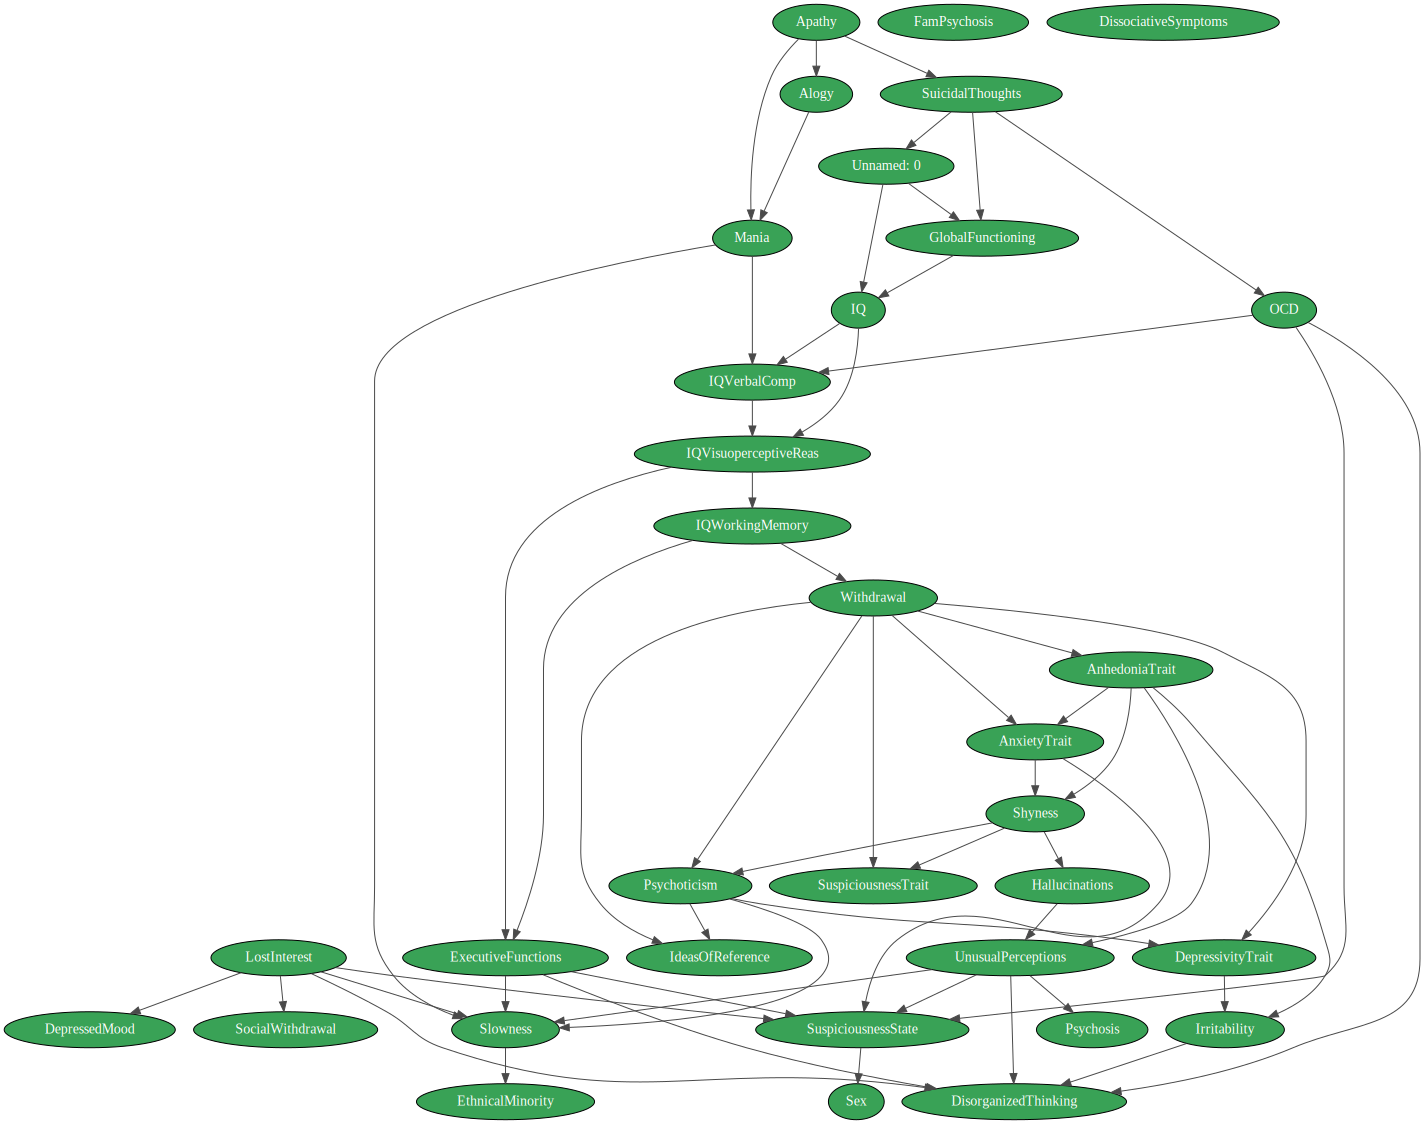

In [15]:
gnb.showBN(clf.bn,size=20,nodeColor={n:0.66 for n in clf.bn.names()},cmap=plt.cm.get_cmap('Greens'))

In [21]:
import pyAgrum.lib.image as gimg
import matplotlib.pyplot as plt
mycmap=plt.get_cmap('Reds')
formyarcs=plt.get_cmap('winter')

def nodevalue(n):
    return 0.5 if n in "aeiou" else 0.7
def arcvalue(a):
    return (10-a[0])*a[1]
def arcvalue2(a):
    return (a[0]+a[1]+5)/22

gimg.export(clf.bn,path+"bn.pdf",nodeColor={n:nodevalue(n) for n in clf.bn.names()},
                              arcColor={a:arcvalue2(a) for a in clf.bn.arcs()},
                              arcWidth={a:arcvalue(a) for a in clf.bn.arcs()})

In [22]:

gimg.exportInference(clf.bn,path+"bnInference.pdf",size=40,nodeColor={n:nodevalue(n) for n in clf.bn.names()},arcColor={a:arcvalue2(a) for a in clf.bn.arcs()},arcWidth={a:arcvalue(a) for a in clf.bn.arcs()})

In [73]:
def getEvs(row: int):
    r = df.loc[[row]].to_dict()
    for key in r:
        r[key] = str(r[key][1])
    return r
tmp = getEvs(1)
tmp

{'PAFIP10y': '1',
 'Sex (male)': '1',
 'Psychosis Family History': '1.0',
 'Hospital Admission': '2',
 'DUI': '0',
 'DUP': '0',
 'STUDENT (yes)': '2',
 'EDUCATIONAL LEVEL (elementary)': '2',
 'SOCIOECONOMIC LEVEL (low)': '2.0',
 'LIVING WITH PARENTS (yes)': '2',
 'MARITAL STATUS (single)': '1',
 'UNEMPLOYED (yes)': '2',
 'ACTIVE (yes)': '1',
 'CANNABIS USE (yes)': '2',
 'BPRS0': '0',
 'SAPS0': '0',
 'SANS0': '1',
 'Positive0': '0',
 'Disorgan0': '1',
 'Negative0': '1',
 'Diagnosis6m': '4',
 'DiagBinar6M': '2',
 'BPRS10y': '1',
 'SAPS10y': '2',
 'SANS10y': '1',
 'Positiva10y': '2',
 'Disorgan10y': '2',
 'Negativa10y': '1',
 'DAS GLOBAL EVAL 10y': '2.0',
 'DAS10ydic': '2.0',
 'Active10y': '2.0',
 'Recovery10m': '2.0'}

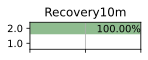

In [74]:
#PAFIP10y,Sex (male),Age,Psychosis Family History,Hospital Admission,DUI,DUP,DAT,DAP,AGE ONSET,STUDENT (yes),
#EDUCATIONAL LEVEL (elementary),SOCIOECONOMIC LEVEL (low),LIVING WITH PARENTS (yes),MARITAL STATUS (single),UNEMPLOYED (yes),
#ACTIVE (yes),CANNABIS USE (yes),BPRS0,SAPS0,SANS0,Positive0,Disorgan0,Negative0,Diagnosis6m,DiagBinar6M,TP_Infancia,TP_AdolescenciaTemprana,
#TP_AdolescenciaTardia,TP_Adulto,TP_General,MEAN PAS,BPRS10y,SAPS10y,SANS10y,Positiva10y,Disorgan10y,Negativa10y,DAS GLOBAL EVAL 10y,DAS10ydic,
#Active10y,Recovery10m
gnb.showPosterior(clf.bn, evs={'PAFIP10y': '1',
 'Sex (male)': '1',
 'Psychosis Family History': '1.0',
 'Hospital Admission': '2',
 'DUI': '0',
 'DUP': '0',
 'STUDENT (yes)': '2',
 'EDUCATIONAL LEVEL (elementary)': '2',
 'SOCIOECONOMIC LEVEL (low)': '2.0',
 'LIVING WITH PARENTS (yes)': '2',
 'MARITAL STATUS (single)': '1',
 'UNEMPLOYED (yes)': '2',
 'ACTIVE (yes)': '1',
 'CANNABIS USE (yes)': '2',
 'BPRS0': '0',
 'SAPS0': '0',
 'SANS0': '1',
 'Positive0': '0',
 'Disorgan0': '1',
 'Negative0': '1',
 'Diagnosis6m': '4',
 'DiagBinar6M': '2',
 'BPRS10y': '1',
 'SAPS10y': '2',
 'SANS10y': '1',
 'Positiva10y': '2',
 'Disorgan10y': '2',
 'Negativa10y': '1',
 'DAS GLOBAL EVAL 10y': '2.0',
 'DAS10ydic': '2.0',
 'Active10y': '2.0',
 'Recovery10m': '2.0'},
                 target='Recovery10m')

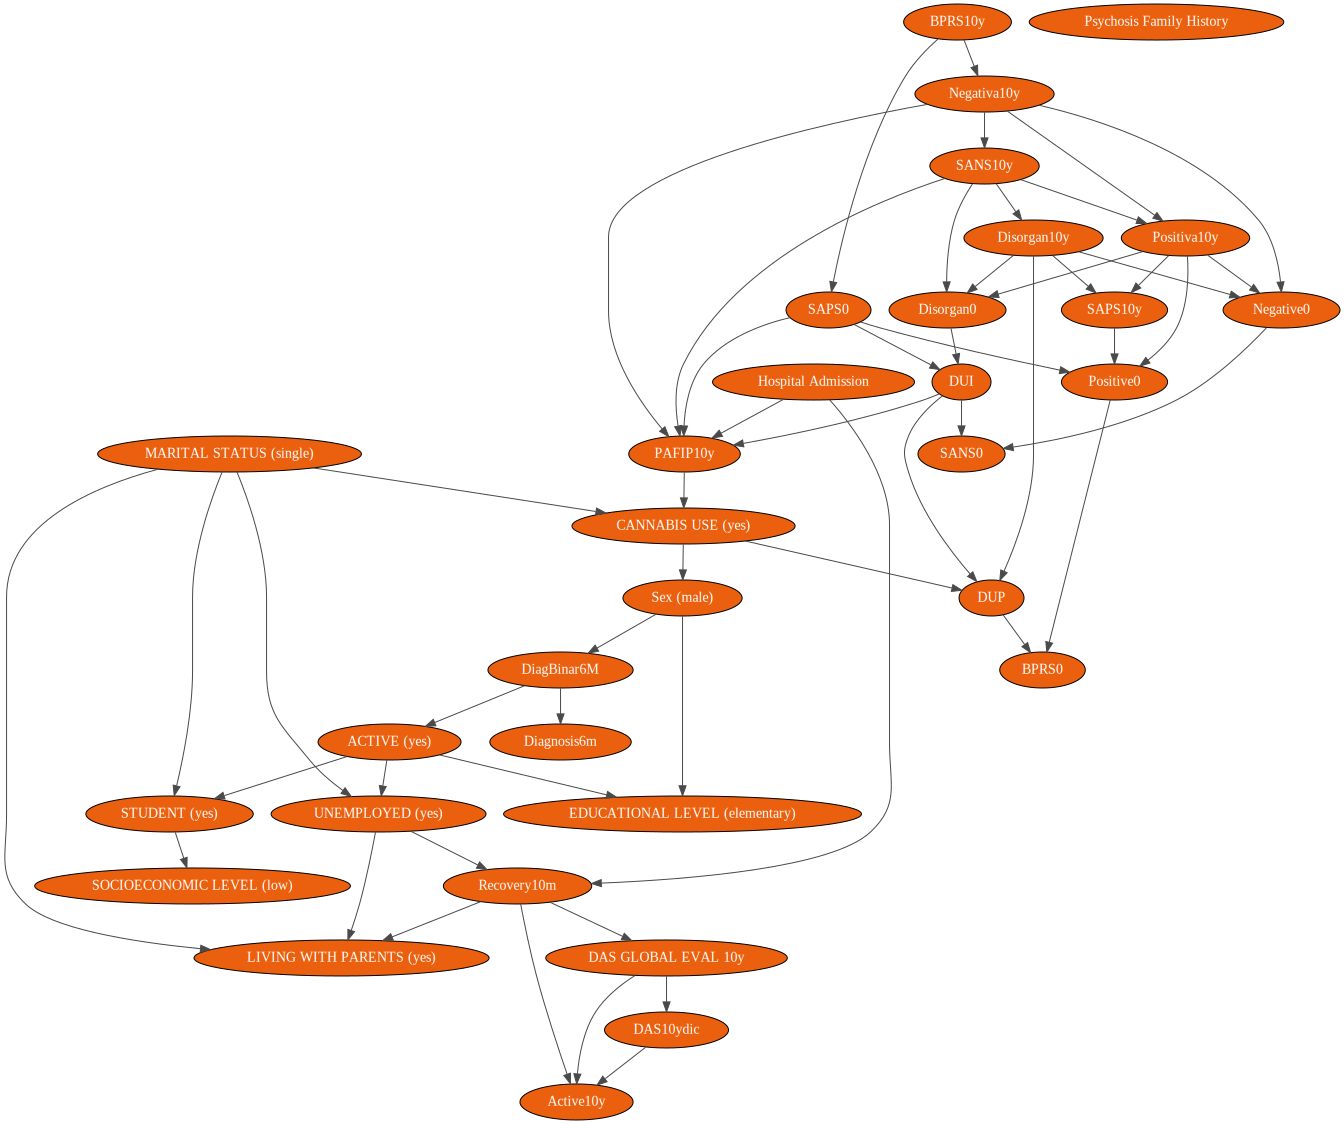

In [75]:
df.to_csv(path + 'template.csv', index = False)

clf = BNEstimator(csv_template=path+'template.csv', class_name='Recovery10m',
                  tabu_arcs=[('Diagnosis6m', 'PAFIP10y')],
                  mandatory_arcs=[('Hospital Admission','Recovery10m'),('UNEMPLOYED (yes)','Recovery10m')],
                  cut_points_percentiles = [5, 50, 95])
_,data = clf.transform(df)

train,test = train_test_split(data ,test_size=0.25, random_state=42)
train.to_csv(path +'train.csv',index=False)
test.to_csv(path +'test.csv',index=False)

clf.fit(train)

gnb.showBN(clf.bn,size=250,nodeColor={n:0.66 for n in clf.bn.names()},cmap=plt.cm.get_cmap('Oranges'))

In [76]:
clf.bn.cpt(clf.bn.idFromName('Recovery10m'))

(pyAgrum.Potential<double>@0x556191c37110) 
             ||  Recovery10m      |
Hospit|UNEMPL||2.0      |1.0      |
------|------||---------|---------|
1     |2     || 0.7624  | 0.2376  |
2     |2     || 0.6040  | 0.3960  |
1     |1     || 0.8787  | 0.1213  |
2     |1     || 0.6846  | 0.3154  |

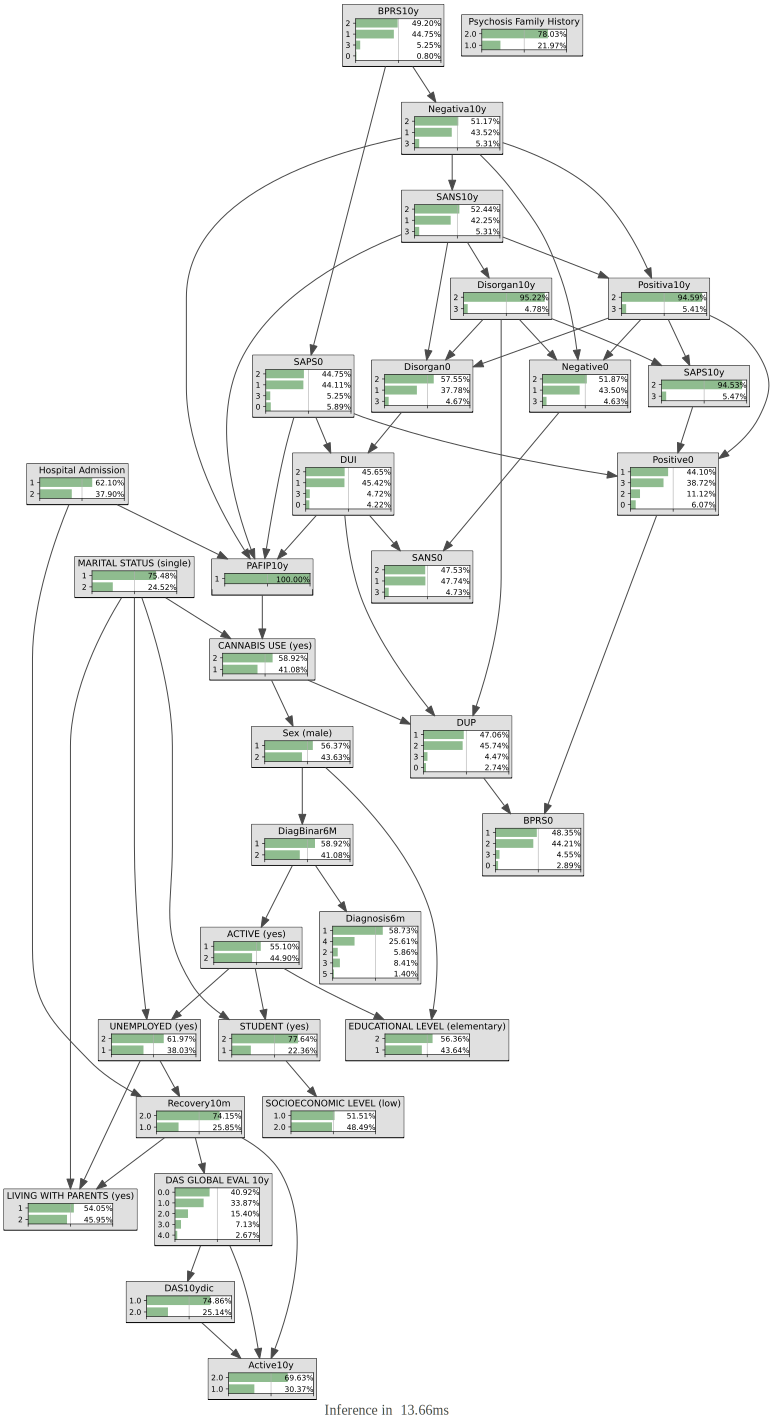

In [77]:
gnb.showInference(clf.bn,size=250)

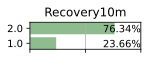

In [78]:
#PAFIP10y,Sex (male),Age,Psychosis Family History,Hospital Admission,DUI,DUP,DAT,DAP,AGE ONSET,STUDENT (yes),
#EDUCATIONAL LEVEL (elementary),SOCIOECONOMIC LEVEL (low),LIVING WITH PARENTS (yes),MARITAL STATUS (single),UNEMPLOYED (yes),
#ACTIVE (yes),CANNABIS USE (yes),BPRS0,SAPS0,SANS0,Positive0,Disorgan0,Negative0,Diagnosis6m,DiagBinar6M,TP_Infancia,TP_AdolescenciaTemprana,
#TP_AdolescenciaTardia,TP_Adulto,TP_General,MEAN PAS,BPRS10y,SAPS10y,SANS10y,Positiva10y,Disorgan10y,Negativa10y,DAS GLOBAL EVAL 10y,DAS10ydic,
#Active10y,Recovery10m

gnb.showPosterior(clf.bn, evs={'Disorgan0':'1', 'LIVING WITH PARENTS (yes)': '2', 'MARITAL STATUS (single)': '2'},
                 target='Recovery10m')

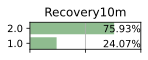

In [79]:
gnb.showPosterior(clf.bn, evs={'UNEMPLOYED (yes)':'2', 'LIVING WITH PARENTS (yes)': '2'},
                 target='Recovery10m')